In [47]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Auto Encoder for Dimensionality Reduction

In [48]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import CancerDataAutoEncoder

In [49]:
# np.random.seed(42)

# # Parameters
# num_samples = 2621
# num_genes = 1800

# # Base clinical data
# clinical_data = {
#     "PatientID": [f"PID_{i}" for i in range(1, num_samples + 1)],
#     "CopyNumberVariant": np.random.randint(0, 10, size=num_samples),
#     "SmokingStatus": np.random.choice([1, 0], size=num_samples),
#     "OverallSurvivalMonths": np.random.uniform(6, 60, size=num_samples).round(2),
# }

# # Simulated gene mutation matrix: binary (0=wildtype, 1=mutated)
# mutation_matrix = np.random.choice([0, 1], size=(num_samples, num_genes), p=[0.97, 0.03])

# # Gene column names
# gene_cols = [f"Gene_{i+1}" for i in range(num_genes)]
# mutation_df = pd.DataFrame(mutation_matrix, columns=gene_cols, index=clinical_data["PatientID"])

# # Combine all data
# cancer_df = pd.concat([pd.DataFrame(clinical_data).set_index("PatientID"), mutation_df], axis=1)

# # Preview
# print(cancer_df.iloc[:, :10].head())  # Just print first 10 columns to avoid overload


In [50]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cancer_df

,SMOKING_PACK_YEARS,SMOKING_HISTORY_Current Reformed Smoker For < Or = 15 Years,SMOKING_HISTORY_Current Reformed Smoker For > 15 Years,"SMOKING_HISTORY_Current Reformed Smoker, Duration Not Specified",SMOKING_HISTORY_Current Smoker,SMOKING_HISTORY_Lifelong Non-Smoker,ONCOTREE_CODE_LUAD,ONCOTREE_CODE_LUSC,ABCA13,ADAMTS12,...,CNA_MUC16,CNA_ZNF536,CNA_RYR1,CNA_ZNF831,CNA_TPTE,CNA_MXRA5,CNA_DMD,CNA_PCDH11X,CNA_GPR112,OS_MONTHS
TCGA-33-AASD-01A-11D-A401-08,84.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,1,1,1,0,-2,1,-1,-1,111.05
TCGA-33-AASL-01A-11D-A401-08,60.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,1,...,0,0,0,0,-1,0,-1,-1,-1,27.17
TCGA-NK-A7XE-01A-12D-A401-08,80.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,...,0,1,1,1,0,1,1,1,1,0.43
TCGA-XC-AA0X-01A-32D-A401-08,30.000000,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0,0,...,-1,2,2,0,0,0,0,0,0,0.20
TCGA-33-AASI-01A-22D-A401-08,60.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,...,-1,1,1,1,-1,-1,1,-1,-1,44.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-44-6775-01A-11D-1855-08,25.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,...,0,0,0,1,1,0,0,0,0,2.70
TCGA-44-6146-01A-11D-1753-08,15.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,-1,0,0,0,0,-1,-1,-1,-1,9.90
TCGA-44-6147-01A-11D-1753-08,35.489939,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,0,...,0,1,1,1,1,0,0,0,0,7.80
TCGA-44-2662-01A-01D-0969-08,56.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1,0,...,-1,1,1,1,1,0,0,0,0,15.80


In [51]:
cancer_ds = CancerDataset(cancer_df)
cancer_ds[0][0].shape

torch.Size([203])

In [52]:
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)


In [53]:
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols)
cancer_dm.setup()

In [54]:
len(cancer_dm.ds_train), len(cancer_dm.ds_val), len(cancer_dm.ds_test)

(558, 186, 187)

In [55]:
#first batch from cancer_dm
batch = next(iter(cancer_dm.train_dataloader()))
batch[0].shape, batch[1].shape

(torch.Size([32, 203]), torch.Size([32, 1]))

In [56]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(CancerDataAutoEncoder(input_size=input_dim, latent_size=20), input_size=(32, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
CancerDataAutoEncoder                    [32, 203]                 --
├─Sequential: 1-1                        [32, 20]                  --
│    └─Linear: 2-1                       [32, 142]                 28,968
│    └─ReLU: 2-2                         [32, 142]                 --
│    └─Dropout: 2-3                      [32, 142]                 --
│    └─Linear: 2-4                       [32, 81]                  11,583
│    └─ReLU: 2-5                         [32, 81]                  --
│    └─Dropout: 2-6                      [32, 81]                  --
│    └─Linear: 2-7                       [32, 20]                  1,640
│    └─ReLU: 2-8                         [32, 20]                  --
│    └─Dropout: 2-9                      [32, 20]                  --
├─Sequential: 1-2                        [32, 203]                 --
│    └─Linear: 2-10                      [32, 81]                  1,701
│

In [57]:
from utils.helper_functions import create_classifier_trainer


trainer, ae_csv_logger, ae_checkpoint = create_classifier_trainer("cancer_auto_encoder")
cancer_ae = CancerDataAutoEncoder(input_size=len(cancer_dm.ds_train[0][0]), latent_size=20, n_layers=3, dropout=0.2)
trainer.fit(
    cancer_ae,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type             | Params | Mode 
---------------------------------------------------------
0 | encoder     | Sequential       | 42.2 K | train
1 | decoder     | Sequential       | 42.4 K | train
2 | loss_metric | MeanSquaredError | 0      | train
3 | val_metric  | MeanSquaredError | 0      | train
4 | test_metric | MeanSquaredError | 0      | train
---------------------------------------------------------
84.6 K    Trainable params
0         Non-trainable params
84.6 K    Total params
0.338     Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [58]:
trainer.test(cancer_ae, datamodule=cancer_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5606667995452881     │
│         test_mse          │    0.5606667995452881     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5606667995452881, 'test_mse': 0.5606667995452881}]

In [59]:
def make_plots(history, title):
    plt.figure(figsize=(12, 5))
    plt.suptitle(title)
    train_history = history.dropna(subset=["train_loss"])
    val_history = history.dropna(subset=["val_loss"])
    # Loss Plot
    plt.plot(train_history["step"], train_history["train_loss"], label="Train Loss", marker="o")
    plt.plot(
        val_history["step"],
        val_history["val_loss"],
        label="Validation Loss",
        marker="o",
        linestyle="-",
    )
    plt.xlabel("step")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()


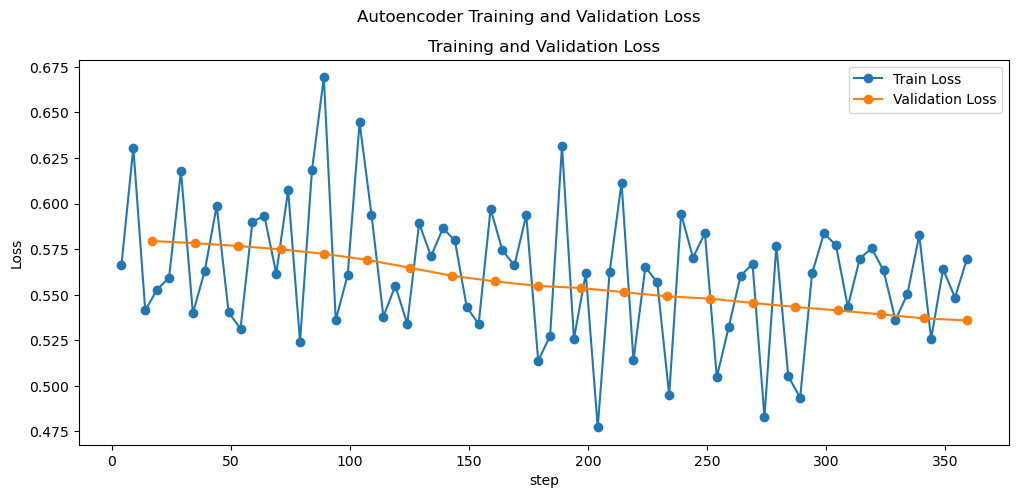

: 

In [ ]:
history = pd.read_csv(ae_csv_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")

In [61]:
import optuna

trial_to_details = {}
def objective(trial):
    latent_size = trial.suggest_int("latent_size", 3, 50)
    n_layers = trial.suggest_int("n_layers", 1, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    input_dim = len(cancer_dm.ds_train[0][0])

    model = CancerDataAutoEncoder(
        input_size=input_dim,
        latent_size=latent_size,
        n_layers=n_layers,
        dropout=dropout,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    trainer.fit(model, datamodule=cancer_dm)

    # Load validation metrics from CSV logger
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse_epoch" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse_epoch"].dropna().values[-1]
    return last_val

# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="autoencoder_study")
study.optimize(objective, n_trials=50, n_jobs=-1)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-14 12:44:55,913] A new study created in memory with name: autoencoder_study


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (cuda), used: True
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
GPU available: True (cuda), used: True
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
GPU available: True (cuda),

: 

: 

In [ ]:
results = study.trials_dataframe()
results.to_csv(f"results/02/hyperparmeter_tuning_results.csv", index=False)

In [ ]:
results

,number,value,datetime_start,datetime_complete,duration,params_dropout,params_latent_size,params_n_layers,state
0,0,0.521161,2025-04-12 22:14:02.700103,2025-04-12 22:25:50.817215,0 days 00:11:48.117112,0.454158,48,1,COMPLETE
1,1,0.556346,2025-04-12 22:14:02.703745,2025-04-12 22:18:14.148911,0 days 00:04:11.445166,0.378959,44,13,COMPLETE
2,2,0.565017,2025-04-12 22:14:02.707162,2025-04-12 22:17:44.474886,0 days 00:03:41.767724,0.479202,23,6,COMPLETE
3,3,0.556206,2025-04-12 22:14:02.709181,2025-04-12 22:18:06.784423,0 days 00:04:04.075242,0.196652,19,13,COMPLETE
4,4,0.556755,2025-04-12 22:14:02.712215,2025-04-12 22:16:49.848599,0 days 00:02:47.136384,0.408676,28,14,COMPLETE
5,5,0.556565,2025-04-12 22:14:02.716328,2025-04-12 22:20:24.625898,0 days 00:06:21.909570,0.433035,32,7,COMPLETE
6,6,0.549161,2025-04-12 22:14:02.719370,2025-04-12 22:25:04.405096,0 days 00:11:01.685726,0.481789,41,2,COMPLETE
7,7,0.556725,2025-04-12 22:14:02.726144,2025-04-12 22:18:34.385458,0 days 00:04:31.659314,0.496100,33,15,COMPLETE
8,8,0.556309,2025-04-12 22:14:02.731990,2025-04-12 22:17:29.543537,0 days 00:03:26.811547,0.269615,28,11,COMPLETE
9,9,0.470119,2025-04-12 22:14:02.736043,2025-04-12 22:26:51.214461,0 days 00:12:48.478418,0.120622,36,5,COMPLETE


In [ ]:
trial_to_details[study.best_trial.number]["checkpoint"].best_model_path

'logs/trial_46/version_1/checkpoints/best_trial_46.ckpt'

In [ ]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/02/best_model.pth
best_model_path = "results/02/best_model.pth"
with open("results/02/results.txt", "w") as f:
    f.write(best_model_path)

NameError: name 'trial_to_details' is not defined

In [ ]:
cancer_dm.save_scaler()

In [ ]:
import json

with open("results/02/best_trial_params.json", "w") as f:
    json.dump(study.best_trial.params, f, indent=4)

In [ ]:
CancerDataAutoEncoder.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    **study.best_trial.params
)

CancerDataAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=203, out_features=149, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0031343232927195652, inplace=False)
    (3): Linear(in_features=149, out_features=95, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0031343232927195652, inplace=False)
    (6): Linear(in_features=95, out_features=41, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0031343232927195652, inplace=False)
    (9): Linear(in_features=41, out_features=39, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=39, out_features=93, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0031343232927195652, inplace=False)
    (3): Linear(in_features=93, out_features=147, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0031343232927195652, inplace=False)
    (6): Linear(in_features=147, out_features=201, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0031343232927195652, inplace=False)
    (9): Linear(in_features=201, out_features=203, bias=Tru

In [ ]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

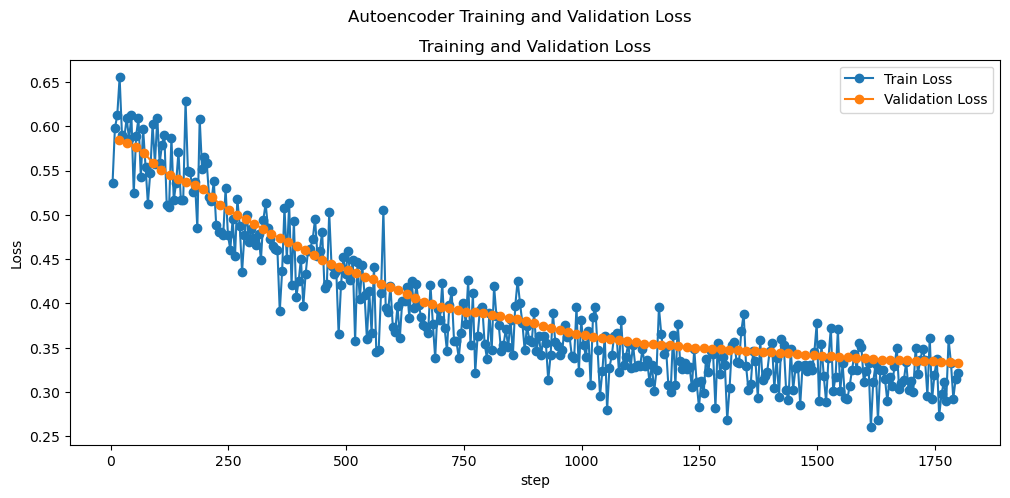

In [ ]:
history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")

make_plots(history, "Autoencoder Training and Validation Loss")